In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
from scipy import interpolate
pd.set_option('display.max_columns', 5000)  # or 1000
pd.set_option('display.max_rows', 5000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import balanced_accuracy_score

In [97]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
print('Input data of all the lakes can be found in Training data folder.')
filename = input('Input data file name (without .csv): ')
all_df = pd.read_csv(filename+'.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Trainning data
Load training data (containing nutrient observations)
Lake name in short: Mueggelsee
Input data of all the lakes can be found in Training data folder.
Input data file name (without .csv): Mueggelsee_Observation_df_nowinter_classification2


In [98]:
print(all_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4643 entries, 0 to 4642
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   4643 non-null   datetime64[ns]
 1   Bloom                  4643 non-null   int64         
 2   MM                     4643 non-null   int64         
 3   thermD                 4643 non-null   float64       
 4   delT                   4643 non-null   float64       
 5   U                      4643 non-null   float64       
 6   AirP                   4643 non-null   float64       
 7   Hum                    4643 non-null   float64       
 8   AirT                   4643 non-null   float64       
 9   SWR                    4643 non-null   float64       
 10  CC                     4643 non-null   float64       
 11  Prec                   4643 non-null   float64       
 12  Ice_d                  4643 non-null   float64       
 13  day

name of iceoff variable:days from iceoff date
Modify iceoff_day? (Y/N)Y


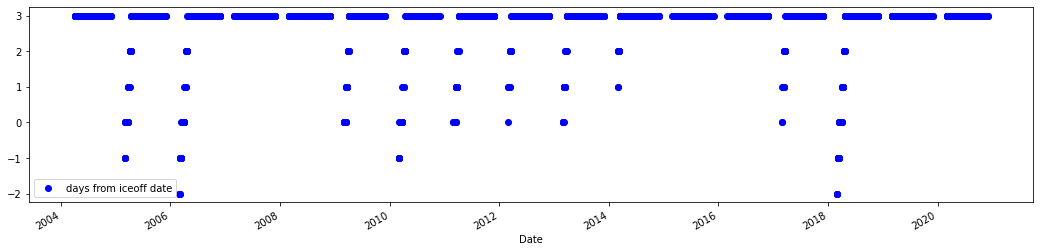

In [99]:
## Modifiy iceoff_day variable
iceoff_name=input('name of iceoff variable:')

def modify_iceoff_day(x,iceoff_name):
    if x[iceoff_name]>=30:
        return 3
    elif (x[iceoff_name]<30)&(x[iceoff_name]>=20):
        return 2
    elif (x[iceoff_name]<20)&(x[iceoff_name]>=10):
        return 1
    elif (x[iceoff_name]<10)&(x[iceoff_name]>=-10):
        return 0
    elif (x[iceoff_name]<-10)&(x[iceoff_name]>=-20):
        return -1
    elif (x[iceoff_name]<-20)&(x[iceoff_name]>=-30):
        return -2
    else:
        return -3

modify=input('Modify iceoff_day? (Y/N)')
if modify=='Y':
    all_df[iceoff_name]=all_df.apply(lambda x:modify_iceoff_day(x,iceoff_name), axis=1)

## categorize ice information
all_df[['Date',iceoff_name]].plot(x='Date',y=iceoff_name,style='bo',figsize=(18,4))
all_df[iceoff_name]=pd.Categorical(all_df[iceoff_name])

In [100]:
## Modifiy ice duration
def modify_ice_d(x,ice_d_name):
    if x[ice_d_name]>60:
        return 'ice_d_long'
    elif (x[ice_d_name]<=60) & (x[ice_d_name]>30):
        return 'ice_d_middle'
    elif (x[ice_d_name]<=30) & (x[ice_d_name]>0):
        return 'ice_d_short'
    else:
        return 'no_ice_d'
ice_d_name=input('Name of ice duration variable:')
modify=input('Modify iceoff_day? (Y/N)')
if modify=='Y':
    all_df[ice_d_name]=all_df.apply(lambda x:modify_ice_d(x,ice_d_name), axis=1)
    
## categorize ice information
all_df[ice_d_name]=pd.Categorical(all_df[ice_d_name])

Name of ice duration variable:Ice_d
Modify iceoff_day? (Y/N)Y


In [103]:
## Get ice-related variables dommies
test_df=all_df.copy()
test_df=pd.concat([test_df,pd.get_dummies(test_df[[iceoff_name,ice_d_name]])],axis=1).drop([iceoff_name,ice_d_name],axis=1)              

In [107]:
print(test_df.columns)
n_feature = int(input('Number of daily features used for training: '))
Daily_f = []
for i in range(n_feature):
    f = input('Feature:')
    Daily_f.append(f)
print(Daily_f)

Index(['Date', 'Bloom', 'MM', 'thermD', 'delT', 'U', 'AirP', 'Hum', 'AirT',
       'SWR', 'CC', 'Prec', 'MLD', 'W', 'SRP', 'TotP', 'NH4', 'NO3', 'Si',
       'Chl', 'Inva_spe', 'days from iceoff date_-2',
       'days from iceoff date_-1', 'days from iceoff date_0',
       'days from iceoff date_1', 'days from iceoff date_2',
       'days from iceoff date_3', 'Ice_d_ice_d_long', 'Ice_d_ice_d_middle',
       'Ice_d_ice_d_short', 'Ice_d_no_ice_d'],
      dtype='object')
Number of daily features used for training: 22
Feature:thermD
Feature:delT
Feature:U
Feature:AirP
Feature:Hum
Feature:AirT
Feature:SWR
Feature:CC
Feature:Prec
Feature:MLD
Feature:W
Feature:Inva_spe
Feature:days from iceoff date_-2
Feature:days from iceoff date_-1
Feature:days from iceoff date_0
Feature:days from iceoff date_1
Feature:days from iceoff date_2
Feature:days from iceoff date_3
Feature:Ice_d_ice_d_long
Feature:Ice_d_ice_d_middle
Feature:Ice_d_ice_d_short
Feature:Ice_d_no_ice_d
['thermD', 'delT', 'U', 'AirP', 'H

In [76]:
Nut_num = int(input('How many nutrients to predict? (put them in order) '))
Nut=[]
for i in range(Nut_num):
    Nut.append(input('Nut_'+str(i+1)+': '))

How many nutrients to predict? (include Chl and put them in order) 5
Nut_1: SRP
Nut_2: TotP
Nut_3: NO3
Nut_4: NH4
Nut_5: Si


In [108]:
def find_best_params(X,y,Classifier=True):
    param_grid = {'n_estimators':[int(x) for x in np.arange(100,500,10)],
             'max_depth':[int(x) for x in np.arange(2,10,1)],
             'min_samples_leaf':[int (x) for x in np.arange(2,10,2)]}

    if Classifier:
        Nut_rf = RandomForestClassifier(class_weight="balanced")#{0:17,1:3}
        RSgrid = RandomizedSearchCV(estimator = Nut_rf,param_distributions = param_grid,scoring='balanced_accuracy',
                                   n_iter = 20,cv = 10,verbose = 1,random_state=101)
    else:
        Nut_rf = RandomForestRegressor()
        RSgrid = RandomizedSearchCV(estimator = Nut_rf,param_distributions = param_grid,scoring='neg_mean_squared_error',
                           n_iter = 20,cv = 10,verbose = 1,random_state=101)

    RSgrid.fit(X,y)
    return RSgrid.best_params_,RSgrid.best_score_

Predict SRP
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 70.39
Predict TotP
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 23.13
Predict NO3
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 0.18
Predict NH4
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 0.06
Predict Si
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 2.18


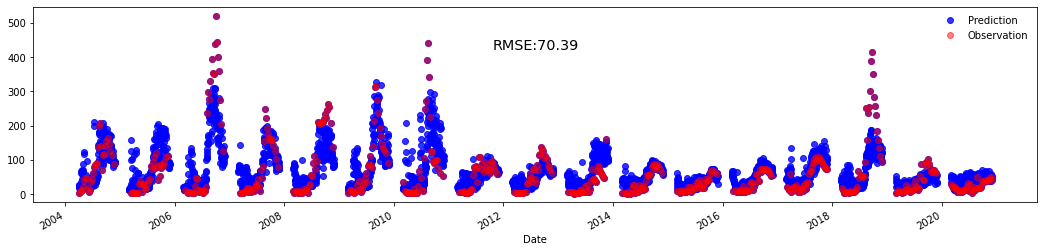

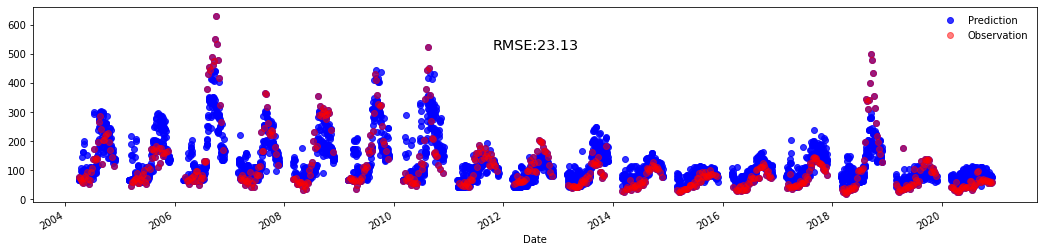

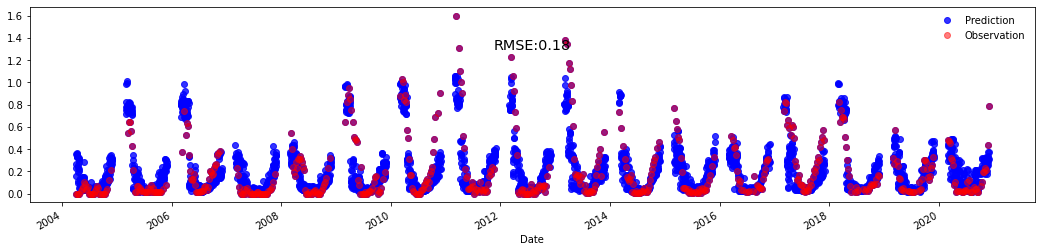

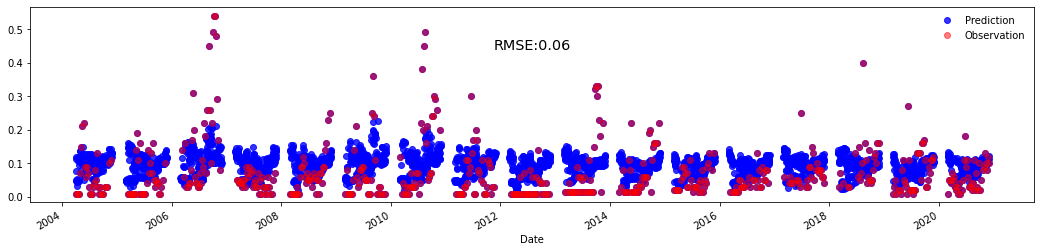

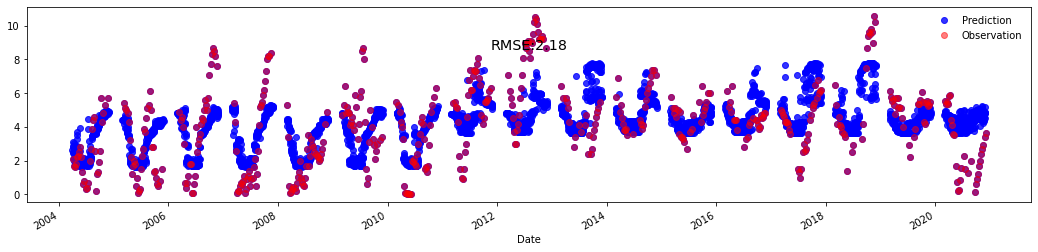

In [109]:
## Reconstruct the dataset for each nutrient variable
os.chdir(cd+'\\RandomForest for nutrient\\'+lakename)
for i in range(len(Nut)):
    print('Predict '+Nut[i])
    f_list=['Date']+Daily_f+[Nut[i]]
    nona_df=test_df[f_list].dropna()
    ### Find the optimal hyperparameters based on the nonan dataset
    train_features=list(nona_df.columns)
    X=nona_df[[s for s in train_features if (s!='Date')&(s!=Nut[i])]]
    y=nona_df[Nut[i]]

    best_params,best_score =find_best_params(X,y,Classifier=False)
        #print(best_params)
    print('RMSE: {}'.format(round(np.sqrt(-best_score),2)))

    ## Predict the nan value based on the best parameter set
    na_df=test_df[f_list].loc[test_df[f_list][Nut[i]].isna()]
    Nut_rf = RandomForestRegressor().set_params(**best_params)
    Nut_rf.fit(X,y)
    test_X=na_df[[s for s in train_features if (s!='Date')&(s!=Nut[i])]]
    yhat=Nut_rf.predict(test_X)
    ## fill the predictive values back to the training dataset
    na_df[Nut[i]]=yhat
    test_df=pd.concat([nona_df,na_df],axis=0).sort_values(by='Date')
    f,ax=plt.subplots(figsize=(18,4))
    test_df.plot(x='Date',y=Nut[i],style='bo',alpha=0.8,ax=ax,label='Prediction')
    nona_df.plot(x='Date',y=Nut[i],style='ro',alpha=0.5,ax=ax,label='Observation')
    ax.legend(frameon=False)
    ax.text(0.5, 0.8, 'RMSE:{}'.format(round(np.sqrt(-best_score),2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax.transAxes,fontsize='x-large')
    f.savefig('RF predict '+Nut[i]+'.png',dpi=300)
    if i<len(Nut)-1:
        test_df=pd.concat([test_df,all_df[Nut[i+1]]],axis=1)
    Daily_f.append(Nut[i])

In [110]:
test_df.to_csv(lakename+'_RF_nutrient prediction.csv',sep='\t',index=False)